# Gantrithor: A machine learning model that detects fraud from transaction information.
This is the initial version for our Gantrithor model,which is based on gradient boost and neural network. Furhter informtation will be added later.

Small updates: Do CV=5

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import time
import tensorflow as tf
import keras
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import copy
from scipy.stats import pearsonr
%matplotlib inline

import os

#root_path = "../input/"
root_path = "Data/"

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


# Read and visualize data

In [2]:
print(os.listdir(root_path))
train_identity = pd.read_csv(root_path+'train_identity.csv')
train_transaction = pd.read_csv(root_path+"train_transaction.csv")

test_identity = pd.read_csv(root_path+'test_identity.csv')
test_transaction = pd.read_csv(root_path+"test_transaction.csv")
print("finish loading data")

### a few notations:
# The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']
finish loading data


In [3]:
# Let's check whether there is a relation between "fraud" and card name
temp = train_transaction[["isFraud","card4"]].dropna()
label_enc = LabelEncoder()
label_enc.fit(temp["card4"])
# Let's visualize some data. See correlation between card and fraud, as well as transaction amount
card_names = list(label_enc.classes_)
for i in range(len(card_names)):
    N = len(temp.loc[temp["card4"]==card_names[i]])
    N_fraud = len(temp[(temp["card4"]==card_names[i])&(temp["isFraud"]==1)])
    print("%s card has %d fraud in %d, fraction=%.2f"%(card_names[i],N_fraud,N,N_fraud/N))




american express card has 239 fraud in 8328, fraction=0.03
discover card has 514 fraud in 6651, fraction=0.08
mastercard card has 6496 fraud in 189217, fraction=0.03
visa card has 13373 fraud in 384767, fraction=0.03


There is no surprice that discover has the highest fraud rate :(

In [4]:
# also check for relation between fraud and visa/master card
temp = train_transaction[["isFraud","card6"]].dropna()
label_enc = LabelEncoder()
label_enc.fit(temp["card6"])
# Let's visualize some data. See correlation between card and fraud, as well as transaction amount
card_names = list(label_enc.classes_)
for i in range(len(card_names)):
    N = len(temp.loc[temp["card6"]==card_names[i]])
    N_fraud = len(temp[(temp["card6"]==card_names[i])&(temp["isFraud"]==1)])
    print("%s card has %d fraud in %d, fraction=%.2f"%(card_names[i],N_fraud,N,N_fraud/N))





charge card card has 0 fraud in 15, fraction=0.00
credit card has 9950 fraud in 148986, fraction=0.07
debit card has 10674 fraud in 439938, fraction=0.02
debit or credit card has 0 fraud in 30, fraction=0.00


No surprice that credit card has a higher fraud rate, since people use debt card more carefully.

In [5]:
# another interesting thing: check the correlation between nan value each row and fraud.
y_nan = train_transaction.isnull().sum(axis=1)
# calculate Pearson's correlation
corr, _ = pearsonr(y_nan, train_transaction["isFraud"])
print('Pearsons correlation between NAN value and fraud: %.3f' % corr)

corr, _ = pearsonr(train_transaction["TransactionAmt"], train_transaction["isFraud"])
print('Pearsons correlation between TransactionAmt and fraud: %.3f' % corr)

temp = train_transaction[["isFraud","card6"]].dropna()
label_enc = LabelEncoder()
label_enc.fit(temp["card6"])

corr, _ = pearsonr(label_enc.transform(temp["card6"]), temp["isFraud"].values)
print('Pearsons correlation between fraud and card name: %.3f' % corr)

Pearsons correlation between NAN value and fraud: -0.128
Pearsons correlation between TransactionAmt and fraud: 0.011
Pearsons correlation between fraud and card name: -0.101


# **This is pretty interesting: The correlation between "card type" and fraud is smaller than the correlation between number of nan value and fraud ratio. ** <br>
**Most people just ignore nan values inside the catalog. Unluckily also include me :( **. But recently I found the nan value is not nonsense. It has its meaning, especially in classification problem. <br>
If there are more nan values, it's highly possible that it's a fraud.


Let's check what happens if we **do not** drop nan values for emaildomain

In [6]:
# Do not always drop nan
temp = train_transaction[["isFraud","P_emaildomain"]]

temp["P_emaildomain"] = temp["P_emaildomain"].fillna(value="NONEweb")

temp.fillna(value="None_web")

label_enc = LabelEncoder()
label_enc.fit(temp["P_emaildomain"])
# Let's visualize some data. See correlation between card and fraud, as well as transaction amount
card_names = list(label_enc.classes_)
N_array = []
N_fraud_array = []
for i in range(len(card_names)):
    N = len(temp.loc[temp["P_emaildomain"]==card_names[i]])
    N_fraud = len(temp[(temp["P_emaildomain"]==card_names[i])&(temp["isFraud"]==1)])
    print("%s card has %d fraud in %d, fraction=%.2f"%(card_names[i],N_fraud,N,N_fraud/N))
    N_array.append(N)
    N_fraud_array.append(N_fraud)
N_array = np.array(N_array)
N_fraud_array = np.array(N_fraud_array)



/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


NONEweb card has 2790 fraud in 94456, fraction=0.03
aim.com card has 40 fraud in 315, fraction=0.13
anonymous.com card has 859 fraud in 36998, fraction=0.02
aol.com card has 617 fraud in 28289, fraction=0.02
att.net card has 30 fraud in 4033, fraction=0.01
bellsouth.net card has 53 fraud in 1909, fraction=0.03
cableone.net card has 3 fraud in 159, fraction=0.02
centurylink.net card has 0 fraud in 205, fraction=0.00
cfl.rr.com card has 0 fraud in 172, fraction=0.00
charter.net card has 25 fraud in 816, fraction=0.03
comcast.net card has 246 fraud in 7888, fraction=0.03
cox.net card has 29 fraud in 1393, fraction=0.02
earthlink.net card has 11 fraud in 514, fraction=0.02
embarqmail.com card has 9 fraud in 260, fraction=0.03
frontier.com card has 8 fraud in 280, fraction=0.03
frontiernet.net card has 5 fraud in 195, fraction=0.03
gmail card has 11 fraud in 496, fraction=0.02
gmail.com card has 9943 fraud in 228355, fraction=0.04
gmx.de card has 0 fraud in 149, fraction=0.00
hotmail.co.uk 

Another interesting thing is to see the correlation between fraud and email domain. Also we should not ignore nan values. You should treat it as a new class name.

/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: fontsize
/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: fontsize


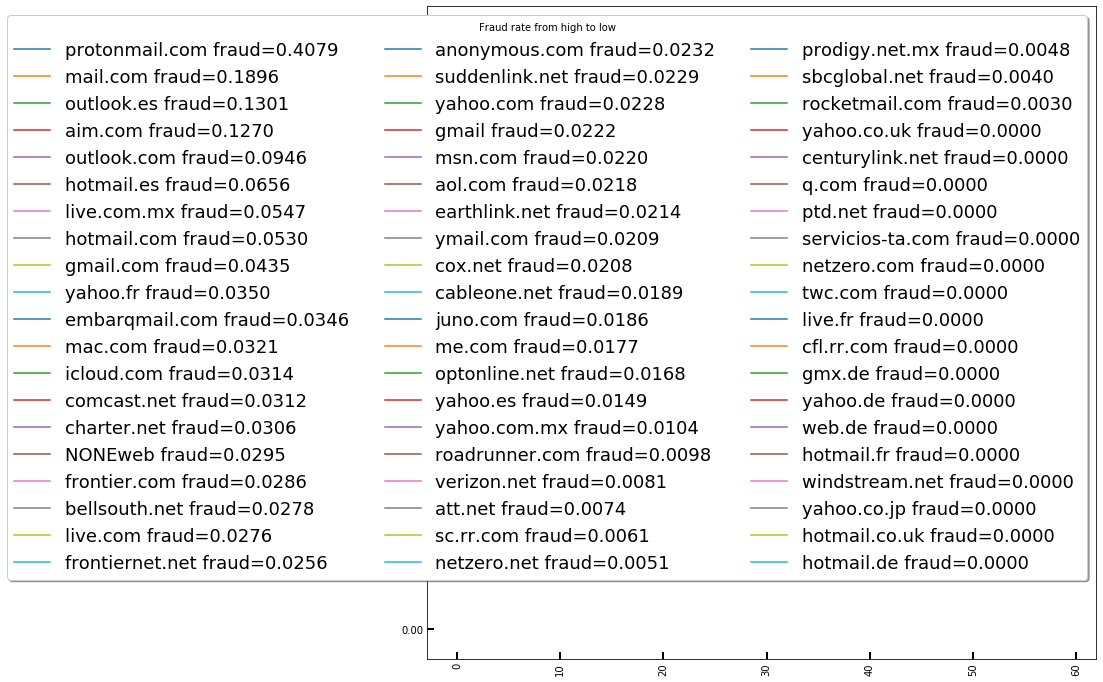

In [7]:
# visualize this result
y = N_fraud_array/N_array
index = np.argsort(y)[::-1]
card_names = np.array(card_names)
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12,12]
font = {'family': 'normal',
        'weight': 'bold',
        'size': 22}

for i in range(len(card_names)):
    plt.plot(i,y[index[i]],label="%s fraud=%.4f"%(card_names[index[i]],y[index[i]]))
# plt.plot(card_names,y,"ko")

plt.xticks(rotation=90)

plt.locator_params(axis='x', fontweight='bold', fontsize=25)
plt.locator_params(axis='y', fontweight='bold', fontsize=25)

plt.tick_params(which='both', width=2, direction="in")
plt.tick_params(which='major', length=7, direction="in")
plt.tick_params(which='minor', length=4, color='k', direction="in")

plt.legend(prop={'size': 18},ncol=3, shadow=True, title="Fraud rate from high to low", fancybox=True)

plt.show()

We will add error bars later. The error bar can be dervied by sigma/sqrt[N], where sigma is derive by bootstrap method.

If you look into the transaction files, you can find a lot of stuff with "C1, C2... V1..". And we don't know the meaning of these values. <br>
One possible way to know what they are is to do "mutual information", which calcualtes P(P(A1,A2)|P(A1* A2)). That's to say, we calcualte how similar are their joint distribution and their marginal distribution. <br>
But it's really time consuming since we need to calculate *each pair of variables.* Thus, we only calculate the "correlation"  (Although mutual information means more than correlation if we do have data (fraud or not))here between variables and fraud

In [8]:
# calculate pearsons correlation between C... V.. and fraud
n = train_transaction.shape[1]
# index_label_name_part = np.r_[11:15,17:n]
index_label_name_part = np.r_[2:n]
label_names_part = train_transaction.iloc[:,index_label_name_part].columns
train_transaction[label_names_part][2:4]

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
2,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Visualize it

# Prepare the dataset for training

In [9]:

def fill_missing_values(df):
    ''' This function imputes missing values with median for numeric columns
        and most frequent value for categorical columns'''
    missing = df.isnull().sum()
    # select missing data
    missing = missing[missing > 0]
    for column in list(missing.index):
        if df[column].dtype == 'object':
            # if it's an object, fill that with the *most common* object in that column
            df[column].fillna(df[column].value_counts().index[0], inplace=True)
        elif df[column].dtype == 'int64' or 'float64' or 'int16' or 'float16':
            df[column].fillna(df[column].median(), inplace=True)

# prepare data for training
def impute_cats(df):
    '''This function converts categorical and non-numeric
       columns into numeric columns to feed into a ML algorithm'''
    # Find the columns of object type along with their column index
    # only select columns with obejcts
    object_cols = list(df.select_dtypes(exclude=[np.number]).columns)
    # return the index for columns with object
    object_cols_ind = []
    for col in object_cols:
        object_cols_ind.append(df.columns.get_loc(col))

    # Encode the categorical columns with numbers
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
    # It's still an object but this time with index from 0 to num_features-1
    ##!! I will modify this part later since I want to rank order these catagorical features by their fraud rate.
    label_enc = LabelEncoder()
    for i in object_cols_ind:
        df.iloc[:, i] = label_enc.fit_transform(df.iloc[:, i])


temp = train_transaction[label_names_part]
# Use mean strategy: Need to think about this
#temp.fillna(temp.mean())
fill_missing_values(temp)
# impute_cats(temp)



/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/pandas/core/generic.py:6288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [10]:


y_pearsons_array_part = []

for i in range(temp.shape[1]):
    if i%50==0:
        print("Doing %d of %d for pearsons correlation"%(i,temp.shape[1]))
    try:
        corr, _ = pearsonr(temp[label_names_part[i]], train_transaction["isFraud"])
        y_pearsons_array_part.append(corr)
    except:
        print("%s is a character"%label_names_part[i])
        label_enc = LabelEncoder()
        label_enc.fit(temp[label_names_part[i]])
        corr, _ = pearsonr(label_enc.transform(temp[label_names_part[i]]), train_transaction["isFraud"])
        y_pearsons_array_part.append(corr)
        
    
y_pearsons_array_part = np.array(y_pearsons_array_part)
    

Doing 0 of 392 for pearsons correlation
ProductCD is a character
card4 is a character
card6 is a character
P_emaildomain is a character
R_emaildomain is a character
M1 is a character
M2 is a character
M3 is a character
M4 is a character
M5 is a character
M6 is a character
Doing 50 of 392 for pearsons correlation
M7 is a character
M8 is a character
M9 is a character
Doing 100 of 392 for pearsons correlation
Doing 150 of 392 for pearsons correlation
Doing 200 of 392 for pearsons correlation
Doing 250 of 392 for pearsons correlation
Doing 300 of 392 for pearsons correlation
Doing 350 of 392 for pearsons correlation


(array([  1.,  13.,  19., 154.,  85.,  35.,  44.,  25.,  10.,   6.]),
 array([-0.15655632, -0.11287931, -0.06920229, -0.02552528,  0.01815174,
         0.06182875,  0.10550577,  0.14918278,  0.1928598 ,  0.23653681,
         0.28021382]),
 <a list of 10 Patch objects>)

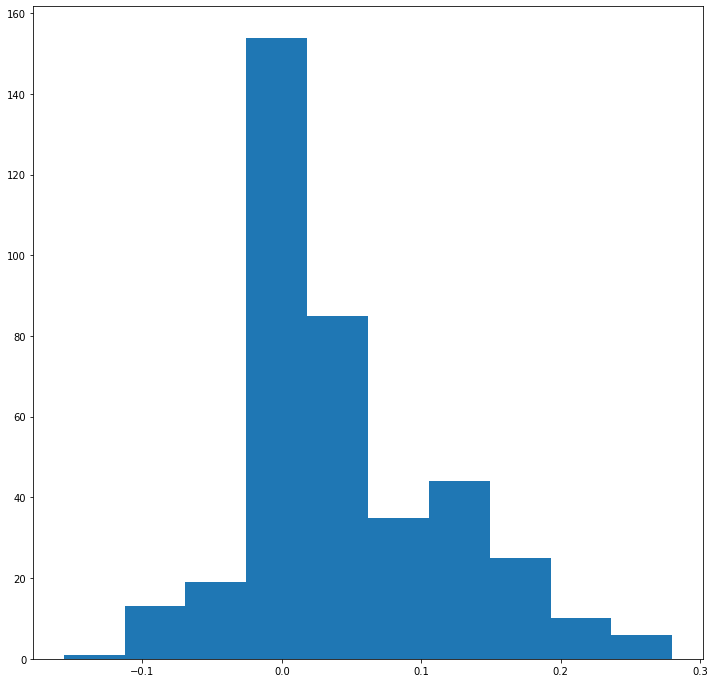

In [11]:
# Visualize the correlation between each column and fraud
plt.hist(y_pearsons_array_part)

In [12]:
# example see what's the correlation between one variable and graud.
name_temp = "M4"
label_enc = LabelEncoder()
label_enc.fit(temp[name_temp])
corr, _ = pearsonr(label_enc.transform(temp[name_temp]), train_transaction["isFraud"])
corr

0.1297299167016531

# One thing I want to add is: y_nan, which is proved to be "highly" correlated to fraud
From the histogram for pearsons correlation, we can see -0.128 is not a small value :)

In [13]:
# absolute value for 1 sigma. Let's select these features
mask = abs(y_pearsons_array_part)>np.percentile(abs(y_pearsons_array_part),32)
np.percentile(abs(y_pearsons_array_part),32)

0.011470233181395348

# I will prepare data for our model (Finally)

In [14]:
N_train = train_transaction.shape[0]
# deal with imbalance:
print(len(train_transaction.loc[train_transaction["isFraud"]==0]),"no-fraud")
print(len(train_transaction.loc[train_transaction["isFraud"]==1]),"fraud")



569877 no-fraud
20663 fraud


In [15]:
# Need to take train_identity into consider:
# pending

In [16]:
# for submission:

y_nan_submission = test_transaction.isnull().sum(axis=1)

X_submission = test_transaction[label_names_part[mask]]

X = temp[label_names_part[mask]]
X["y_nan"] = y_nan
X_submission["y_nan"] = y_nan_submission
fill_missing_values(X_submission)
print(X.shape)

# concatenate:
X = pd.concat([X,X_submission])
print(X.shape,X_submission.shape)

/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


(590540, 267)
(1097231, 267) (506691, 267)


In [17]:

# remember to add our y_nan to X:

# train_transaction["isFraud"].isnull().sum() no nan value for y. Good 



## It seems repeating the samples makes the prediction worse. So I'm not sure whether it's a good method
# repeat temp for 56/20=28 times



"""

y = train_transaction["isFraud"]


X_repeat = X.loc[train_transaction["isFraud"]==1]
y_repeat = y.loc[train_transaction["isFraud"]==1]
X_repeat.shape

for i in range(28):
    X = X.append(X_repeat,ignore_index=True)
    y = y.append(y_repeat,ignore_index=True)

print("Done")
print(X.shape,y.shape)

"""
    
    



'\n\ny = train_transaction["isFraud"]\n\n\nX_repeat = X.loc[train_transaction["isFraud"]==1]\ny_repeat = y.loc[train_transaction["isFraud"]==1]\nX_repeat.shape\n\nfor i in range(28):\n    X = X.append(X_repeat,ignore_index=True)\n    y = y.append(y_repeat,ignore_index=True)\n\nprint("Done")\nprint(X.shape,y.shape)\n\n'

In [18]:
# Here we will use another method which is a little different than one hot encoder:
# rank the rellation between categorical data and fraud and encode them:


In [19]:
# one hot encoder:
one_hot_X = pd.get_dummies(X)

In [20]:
print("Finish data preparation")

Finish data preparation


In [23]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
y = train_transaction["isFraud"]


# Use XGBoost to have a try

In [ ]:
# remember this is a very simple toy model which doesn't use any train_identify file or grid search
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
time_start = time.time()
params={}
params['gpu_id'] = 0
params['max_bin'] = 1024
params['tree_method'] = 'gpu_hist'

# regressor is also okay
# need more than 10k trees.

model = XGBClassifier(n_estimators=20000, verbose_eval=True,n_jobs=-1,**params)
# Doing k fold:
accuracy_array = []
AUROC_array = []
n_k_fold=10
model_dic = {}

for i in range(n_k_fold):
    print("Doing k fold %d of %d"%(i,n_k_fold))
    X_train, X_test, y_train, y_test = train_test_split(one_hot_X[:N_train], y, test_size = 0.2, shuffle = True)
    model.fit(X_train, y_train)
    # predict:
    Y_predict_test = model.predict(X_test).ravel()
    mask_good = abs(Y_predict_test - y_test) < 0.05

    # print("Good=%d Bad=%d" % (len(Y_predict_test[mask_good]), len(Y_predict_test) - len(Y_predict_test[mask_good])))
    acc_i = len(Y_predict_test[mask_good]) / len(Y_predict_test)

    # AUROC:
    prob = model.predict_proba(X_test)

    AUROC_i = roc_auc_score(y_test, prob[:, 1])
    
    print("ACC=%.4f AUROC=%.4f"%(acc_i,AUROC_i))
    accuracy_array.append(acc_i)
    AUROC_array.append(AUROC_i)
    model_dic[str(i)] = model
    
accuracy_array = np.array(accuracy_array)
AUROC_array = np.array(AUROC_array)
print("K_fold_results")
print("ACC=%.4f %.4f"%(np.nanmedian(accuracy_array),np.nanstd(accuracy_array)))

print("AUROC=%.4f %.4f"%(np.nanmedian(AUROC_array),np.nanstd(AUROC_array)))




print("Time it takes using GPU=%.2f"%(time.time()-time_start))



In [37]:
print("ACC=%.4f %.4f"%(np.nanmedian(accuracy_array),np.nanstd(accuracy_array)))

print("AUROC=%.4f %.4f"%(np.nanmedian(AUROC_array),np.nanstd(AUROC_array)))




ACC=0.9792 0.0003
AUROC=0.9202 0.0018


# for submission

0.0018364725542361687

In [ ]:
# for submission:

submission_csv = pd.read_csv(root_path+"sample_submission.csv")

X_submission = one_hot_X[N_train:]
fill_missing_values(X_submission)
# for submission:

df = X_submission

Y_predict_test_prob_all = []
for i in range(n_k_fold):
    print("Predicting k fold %d of %d"%(i,n_k_fold))
    model_i = model_dic[str(i)]
    Y_predict_test_prob_i = model_i.predict_proba(df)
    Y_predict_test_prob_all.append(Y_predict_test_prob_i[:,1])
Y_predict_test_prob_all = np.array(Y_predict_test_prob_all)

Y_predict_test_prob = np.nanmedian(Y_predict_test_prob_all,axis=0)
print("Finish predicting")


# probability

submission_csv["isFraud"]=Y_predict_test_prob
submission_csv.to_csv("submissions/Gantrithor_v2_2_prob.csv", index=False)


Predicting k fold 0 of 10
Predicting k fold 1 of 10
Predicting k fold 2 of 10
Predicting k fold 3 of 10
Predicting k fold 4 of 10
Predicting k fold 5 of 10
Predicting k fold 6 of 10


In [ ]:
plt.hist(Y_predict_test_prob)

# I will add grid search here later, which is really time consuming

# Let's look at ROC curve and calculate F1 score.

AUC: 0.96


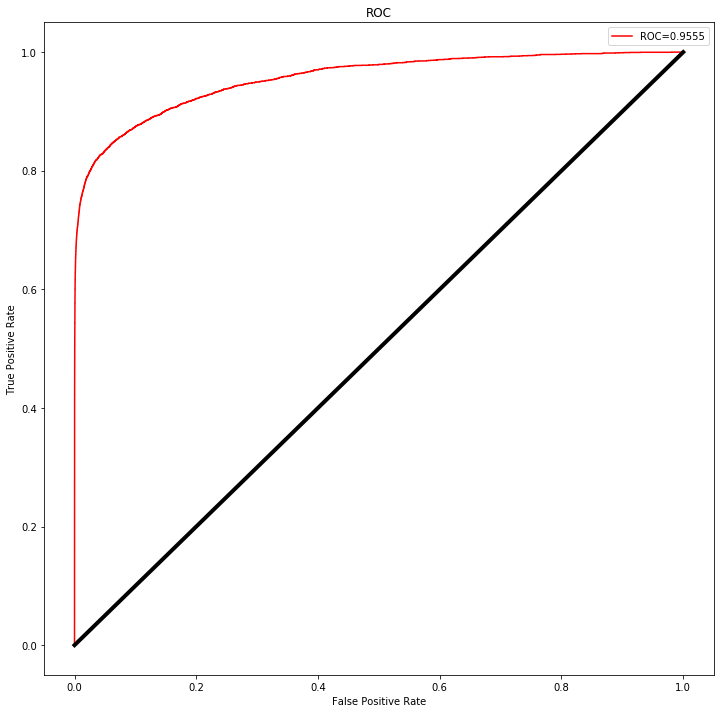

In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def confusion_matrix(y_pred,y_true):
    TP = len(y_pred[(y_pred==1)&(y_true==1)])
    TN = len(y_pred[(y_pred==1)&(y_true==0)])
    # type1 error : false alarm
    FP = len(y_pred[(y_pred==1)&(y_true==0)])
    # type 2 error. Fail to make alarm
    FN = len(y_pred[(y_pred==0)&(y_true==1)])
    
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    accuracy = (TP+TN)/len(y_pred)
    
    f1_score = 2/(1/precision+1/recall)
    return TP,TN,FP,FN,recall,precision,accuracy,f1_score

testy = y_test
prob = model.predict_proba(X_test)
probs = prob[:,1]



auc = roc_auc_score(testy, probs)
print('AUC: %.2f' % auc)

## draw ROC:
fpr, tpr, thresholds = roc_curve(testy, probs)

plt.plot(fpr, tpr, color='r', label='ROC=%.4f'%auc)
plt.plot([0, 1], [0, 1], color='k',linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()


([array([  5044.,    769.,    601.,    597.,    623.,    697.,   1076.,
           1656.,   3693., 491935.]),
  array([491935.,   3693.,   1656.,   1076.,    697.,    623.,    597.,
            601.,    769.,   5044.])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 2 Lists of Patches objects>)

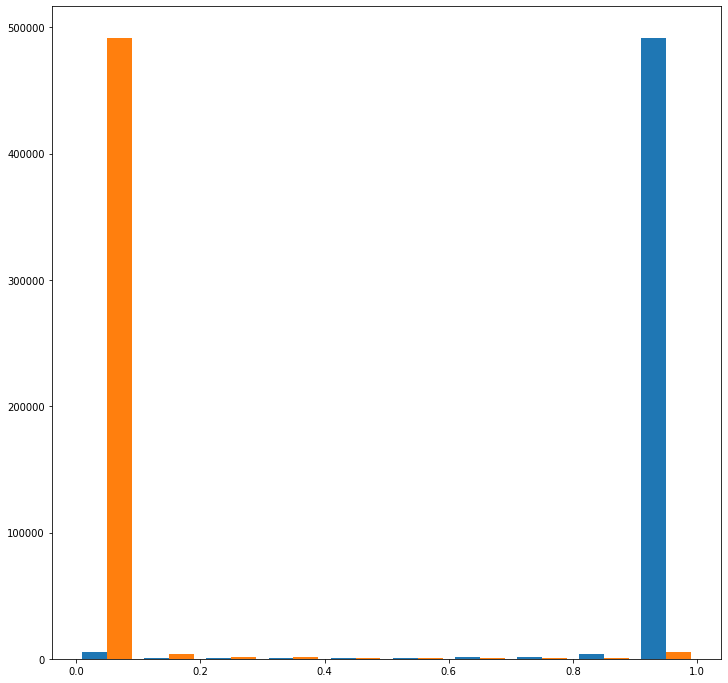

In [44]:
plt.hist(Y_predict_test_prob)

(array([491935.,   3693.,   1656.,   1076.,    697.,    623.,    597.,
           601.,    769.,   5044.]),
 array([3.469935e-17, 1.000000e-01, 2.000000e-01, 3.000000e-01,
        4.000000e-01, 5.000000e-01, 6.000000e-01, 7.000000e-01,
        8.000000e-01, 9.000000e-01, 1.000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

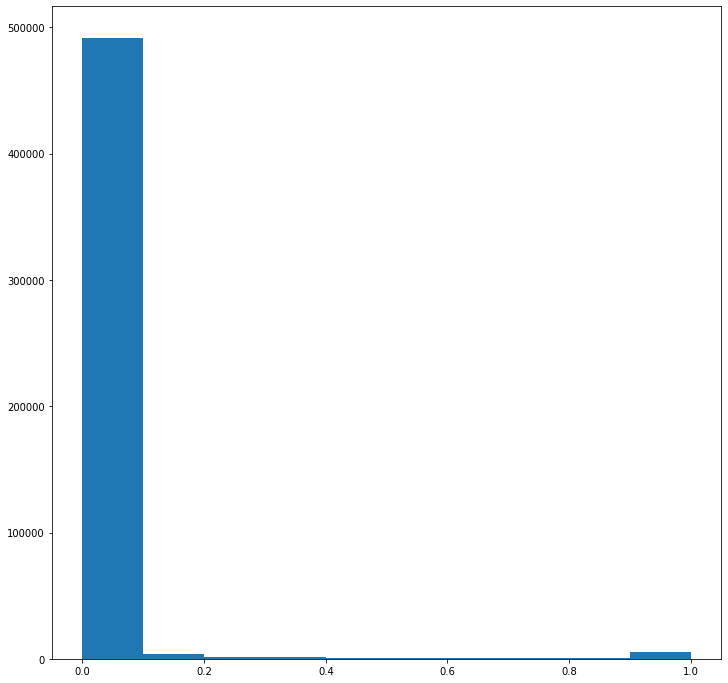

In [46]:
import pickle
# save it:
pickle.dump(model, open("Gantrithor_v2.pkl", "wb"))
print("Done")

Done
